In [ ]:
"""
Brazilian E-Commerce Public Dataset by Olist
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
100,000 Orders with product, customer and reviews info
"""

Primer paso proceder a descargar el dataset

In [4]:
import kagglehub

In [5]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

In [6]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brazilian-ecommerce


✅ Paso 1: Instalar e importar PySpark
Ejecuta primero este bloque:

In [9]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, sum

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("EcommerceAnalysis") \
    .getOrCreate()

✅ Paso 2: Cargar el CSV (por ejemplo olist_order_items_dataset.csv)
Busca el nombre del archivo que quieres procesar (como olist_order_items_dataset.csv) y cárgalo así:

In [11]:
df = spark.read.csv("/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)

+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|48436dade18ac8b2b...|2017-09-19 09:45:35| 58.9|        13.29|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|dd7ddc04e1b6c2c61...|2017-05-03 11:05:13|239.9|        19.93|
|000229ec398224ef6...|            1|c777355d18b72b67a...|5b51032eddd242adc...|2018-01-18 14:48

🧩 Paso 4: Cargar los demás datasets necesarios

In [12]:
# Cargar productos
products = spark.read.csv("/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv", header=True, inferSchema=True)

# Cargar órdenes
orders = spark.read.csv("/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv", header=True, inferSchema=True)

# Verificamos esquemas
products.printSchema()
orders.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: integer (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



🔗 Paso 5: Unir DataFrames


In [ ]:
# Ahora vamos a unir df (order_items) con products y orders:

In [13]:
# Join con productos (por product_id) para obtener la categoría
df_joined = df.join(products, on='product_id', how='inner')

# Join con órdenes (por order_id) para obtener la fecha
df_joined = df_joined.join(orders.select('order_id', 'order_purchase_timestamp'), on='order_id', how='inner')


🧠 Paso 6: Agregar columnas de año, mes y total
python
Copiar código


In [15]:
from pyspark.sql.functions import to_timestamp, date_format

# Convertir timestamp y extraer mes y año
df_joined = df_joined.withColumn("order_date", to_timestamp("order_purchase_timestamp")) \
                     .withColumn("year", year("order_date")) \
                     .withColumn("month", month("order_date")) \
                     .withColumn("total_price", col("price") * col("order_item_id"))  # Approx. total por ítem


📊 Paso 7: Agrupar por categoría y mes
python
Copiar código


In [16]:
df_summary = df_joined.groupBy("product_category_name", "year", "month") \
                      .agg(sum("total_price").alias("total_sales")) \
                      .orderBy("year", "month", "total_sales", ascending=[True, True, False])

df_summary.show(20, truncate=False)


+----------------------+----+-----+------------------+
|product_category_name |year|month|total_sales       |
+----------------------+----+-----+------------------+
|beleza_saude          |2016|9    |269.94            |
|moveis_decoracao      |2016|9    |105.78999999999999|
|telefonia             |2016|9    |59.5              |
|moveis_decoracao      |2016|10   |7264.470000000001 |
|perfumaria            |2016|10   |6073.300000000001 |
|beleza_saude          |2016|10   |4832.1            |
|brinquedos            |2016|10   |4779.98           |
|consoles_games        |2016|10   |3882.2600000000007|
|relogios_presentes    |2016|10   |3360.2400000000002|
|esporte_lazer         |2016|10   |3333.64           |
|climatizacao          |2016|10   |2935.29           |
|market_place          |2016|10   |2652.59           |
|automotivo            |2016|10   |2028.25           |
|bebes                 |2016|10   |1829.9500000000003|
|utilidades_domesticas |2016|10   |1816.67           |
|informati

📦 Exportación

In [17]:
# Convertimos a Pandas para guardarlo fácilmente
df_pandas = df_summary.toPandas()

# Guardamos como archivo CSV
df_pandas.to_csv("ventas_por_categoria.csv", index=False)


⬇️ Descargar el archivo
Después de ejecutarlo, usa este bloque para descargar el archivo desde Colab:

In [18]:
from google.colab import files
files.download("ventas_por_categoria.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Siguiente paso se crea un tablero en Power BI

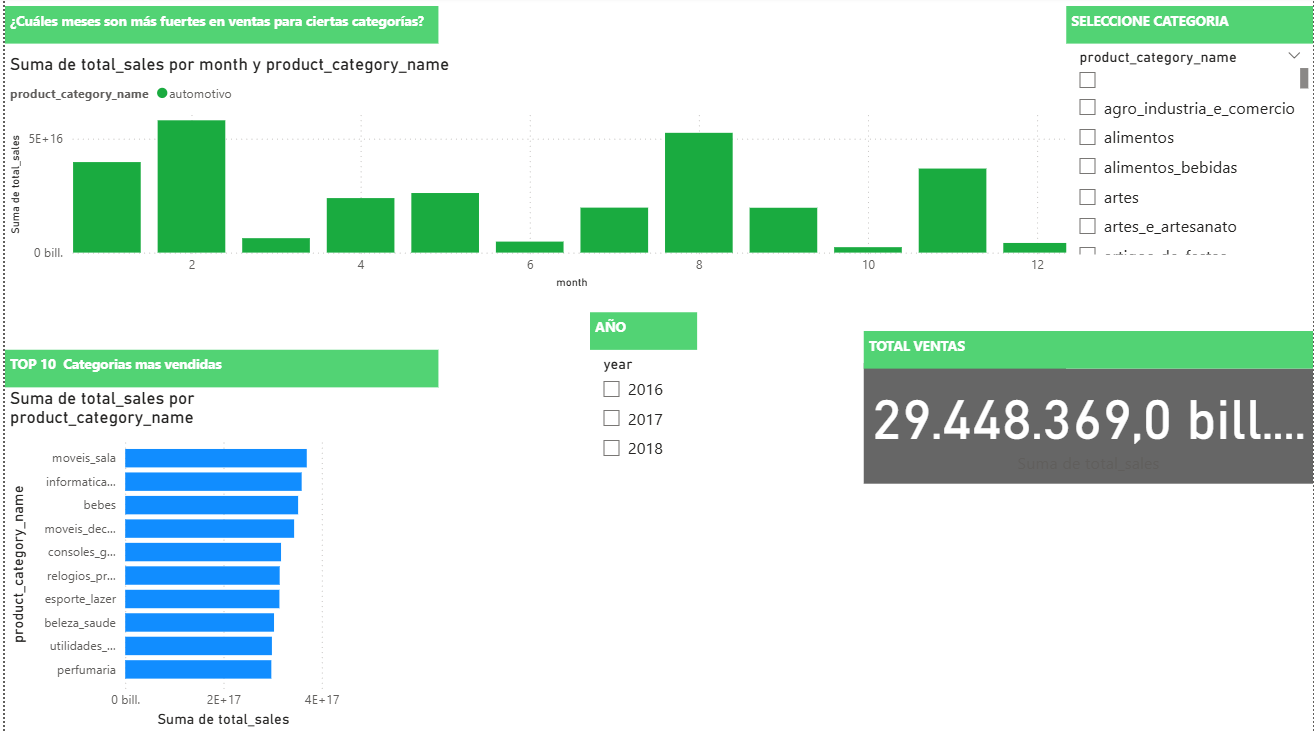